In this notebook, we will train a convolutional neural network for image classification using transfer learning. <br><br>
There are two major transfer learning techniques:
- <b>Finetuning the convnet</b>: not only replace and retrain the classifier on top of the ConvNet on the new dataset, but also fine-tune the weights of the pretrained network by continuing the backpropagation. It is possible to fine-tune all the layers of the ConvNet, or it’s possible to keep some of the earlier layers fixed (due to overfitting concerns) and only fine-tune some higher-level portion of the network.<br><br>
- <b>ConvNet as fixed feature extractor</b>: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [1]:
# Import necessary libraries

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode


### Load Data
We will use torchvision and torch.utils.data packages for loading the data.

The problem we’re going to solve today is to train a model to classify <b>ants</b> and <b>bees</b>. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # randomly crop first and then resize it to size (224, 224)
        transforms.RandomHorizontalFlip(),  # HorizontalFlip
        transforms.ToTensor(), # RBG images converted from [0, 255] to [0, 1]
        # Normalize(mean, std): mean and std are precalculated from imagenet training sets, resulting in [-1, 1]
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),  # resize it to (256, 256)
        transforms.CenterCrop(224), # crop img from center to get (224, 224)
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
# process the images through data_transforms to get image_datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes  # ['ants', 'bees']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize a few images
Let’s visualize a few training images so as to understand the data augmentations.

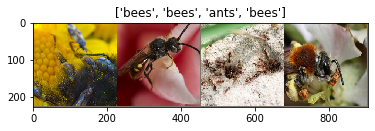

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    # transpose uses to swap the position of dimension, in this example: (N, H, W) to (H, W, N)
    inp = inp.numpy().transpose((1, 2, 0))   
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) # clip(a, a_min, a_max, out=None), uses to limit the value of matrix a to [a_min, a_max]
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Training the Model
Now, let’s write a general function to train a model. Here, we will illustrate:
- Scheduling the learning rate
- Saving the best model

In the following, parameter `scheduler` is an LR scheduler object from `torch.optim.lr_scheduler`.

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions
Generic function to display predictions for a few images

In [23]:
def visualize_model(model, num_images=6):
    # model is in train mode at default, so model.training = True
    # here, we need to make predictions, so model.training sets to false
    was_training = model.training 
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1) # torch.max(a, 0): get the max value of tensor in rows, 1 represents in columns

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        print(was_training)

### Finetuning the Convnet
Load a pretrained model and reset final fully connected layer.

In [16]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\nicho/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


### Train and evaluate
It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [17]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5876 Acc: 0.6967
val Loss: 0.1982 Acc: 0.9477

Epoch 1/24
----------
train Loss: 0.4075 Acc: 0.8279
val Loss: 0.2064 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.4087 Acc: 0.8402
val Loss: 0.1262 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4366 Acc: 0.8074
val Loss: 0.2740 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.7210 Acc: 0.7787
val Loss: 1.1849 Acc: 0.6928

Epoch 5/24
----------
train Loss: 0.7108 Acc: 0.7869
val Loss: 0.6479 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.6918 Acc: 0.7992
val Loss: 0.3705 Acc: 0.8824

Epoch 7/24
----------
train Loss: 0.4592 Acc: 0.8525
val Loss: 0.2631 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.4467 Acc: 0.8361
val Loss: 0.2846 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.3685 Acc: 0.8238
val Loss: 0.2982 Acc: 0.8954

Epoch 10/24
----------
train Loss: 0.3735 Acc: 0.8525
val Loss: 0.2428 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3663 Acc: 0.8484
val Loss: 0.2380 Acc: 0.9085

Ep

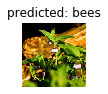

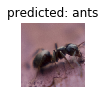

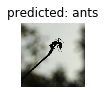

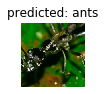

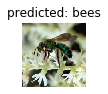

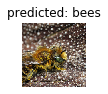

In [24]:
# Visualizing the predictions
visualize_model(model_ft)

### ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set `requires_grad = False` to freeze the parameters so that the gradients are not computed in `backward()`.

In [25]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate
On CPU this will take about half the time compared to previous scenario. This is expected as gradients don’t need to be computed for most of the network. However, forward does need to be computed.

In [26]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7079 Acc: 0.6066
val Loss: 0.1940 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.5468 Acc: 0.7746
val Loss: 0.2806 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.4682 Acc: 0.8279
val Loss: 0.1681 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.4777 Acc: 0.7951
val Loss: 0.1888 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4793 Acc: 0.7746
val Loss: 0.1581 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.3926 Acc: 0.8279
val Loss: 0.1656 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.4491 Acc: 0.7869
val Loss: 0.3037 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.3467 Acc: 0.8484
val Loss: 0.1902 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.4089 Acc: 0.8197
val Loss: 0.1762 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3877 Acc: 0.8279
val Loss: 0.1786 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3979 Acc: 0.8484
val Loss: 0.1848 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.4564 Acc: 0.7500
val Loss: 0.1805 Acc: 0.9412

Ep

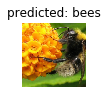

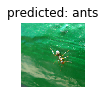

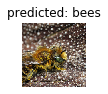

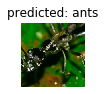

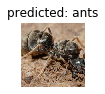

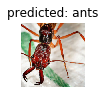

In [27]:
visualize_model(model_conv)

plt.ioff()
plt.show()